In [7]:
import sys
sys.path.append('/home3/ebrahim/isr/')
from RNNcell import RNN_one_layer
from datasets import OneHotLetters, OneHotLetters_test
from run_test_trials import run_test_trials
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import wandb
device = torch.device("cpu")
import seaborn as sns
import scipy
from sklearn.decomposition import PCA
from torch.utils.data import Dataset
import pickle
import pandas as pd
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr

In [2]:
# define functions for later
def softmax(probs):
    return np.exp(probs)/np.sum(np.exp(probs+1e-6))

def sigmoid(probs):
    return 1 / (1 + np.exp(-probs))

def clipper(probs):
    return np.clip(probs, 0, 1.0)

def vec_mag(vec):
    return np.sqrt(np.sum(vec**2))

def pearson_corr(vec1, vec2):
    vec1_centered = vec1 - np.mean(vec1)
    vec2_centered = vec2 - np.mean(vec2)
    vec1_var = np.var(vec1)
    vec2_var = np.var(vec2)
    return np.dot(vec1_centered, vec2_centered)

def cosine_sim(vec1, vec2):
    vec1mag = vec_mag(vec1)
    vec2mag= vec_mag(vec2)
    return round(np.dot(vec1, vec2) / (vec1mag * vec2mag),3)

# define functions for later
def softmax(probs):
    return np.exp(probs)/np.sum(np.exp(probs))

def sigmoid(probs):
    return 1 / (1 + np.exp(-probs))

In [3]:
# load model
base = '/home3/ebrahim/isr/'
modelPATH_arr = ['feedback_onehot_26_SGD_noise_0.0_nobias', 'Stateful_3_1_Adam_double_trial_True_clipping_True', 
'Stateful_3_1_SGD_double_trial_True_clipping_True', 'rosy-sweep-1']

runPATH_arr = ["ebrahimfeghhi/serial_recall_RNNs/gd12r252", 'ebrahimfeghhi/isr/wia7ndsz', 'ebrahimfeghhi/isr/6ai7wfpx', 
'ebrahimfeghhi/isr/3q80gyqg']

i = 3

api = wandb.Api()
run = api.run(runPATH_arr[i])
config = run.config
saved_info = torch.load(base + 'saved_models/' +  modelPATH_arr[i]  + '/model_human.pth')
model = RNN_one_layer(config['num_letters']+2, config['hs'], config['num_letters']+2, noise_std=config['noise_std'],
                        feedback_bool=True, bias=False, alpha_s=config['alpha_s'])
model.load_state_dict(saved_info['model_state_dict'])


model_linear = RNN_one_layer(config['num_letters']+2, config['hs'], config['num_letters']+2, noise_std=config['noise_std'],
                        feedback_bool=True, bias=False, nonlin='linear')
model_linear.load_state_dict(saved_info['model_state_dict'])


<All keys matched successfully>

In [8]:
config['input_size'] = config['output_size'] = 27
config['stateful'] = config['plastic'] = False
config['delay_start'] = config['delay_middle'] = 0
config['test_path_lists'] = 'test_set/test_lists_dict_small.pkl'

In [5]:
for name, param in model.named_parameters():
    if name == 'h2o.weight':
        h2o = param.detach().numpy()
    if name == 'RNN.o2h.weight':
        o2h = param.detach().numpy()
    if name == 'RNN.h2h.weight':
        h2h = param.detach().numpy()
    if name == 'RNN.i2h.weight':
        i2h = param.detach().numpy()

print("Hidden 2 output shape: ", h2o.shape)
print("Output 2 hidden shape: ", o2h.shape)
print("Hidden 2 hidden shape: ", h2h.shape)
print("Input 2 hidden shape: ", i2h.shape)

Hidden 2 output shape:  (28, 200)
Output 2 hidden shape:  (200, 28)
Hidden 2 hidden shape:  (200, 200)
Input 2 hidden shape:  (200, 28)


In [5]:
rtt = run_test_trials(model, 0.5)
rtt.run_model(device, 1, config, base, ignore_end_cue=False)
correct_trial_indices = rtt.correct_trials()
frac_correct = correct_trial_indices.shape[0]/rtt.y_test_recall.shape[0]
print(f"Fraction of correct trials (length 1): {frac_correct: 0.3f}")
h_stacked = rtt.h_stacked
print("Hidden activity shape: ", h_stacked.shape)

Fraction of correct trials (length 1):  0.962
Hidden activity shape:  torch.Size([26, 7, 200])


In [8]:
def rnn_step(h, y, i):
    h_new = sigmoid(h@h2h.T + y@o2h.T + i@i2h.T)
    o_new = softmax(h_new@h2o.T)
    return o_new

In [9]:
# Let's evaluate the softmax probs corresponding to the correct letter
h_stacked_letter = h_stacked[0].detach().numpy()
output_letter = []
for i in range(26):
    out_letter = softmax(h_stacked_letter[i] @ h2o.T)
    output_letter.append(out_letter[i])

In [10]:
# testing if one timestep recurrent dynamics suppress the letter
output_letter_Wrec = []
for i in range(26):
    next_timestep_no_input = sigmoid(h_stacked_letter[i]@h2h.T)
    out_letter = softmax(next_timestep_no_input@h2o.T)
    output_letter_Wrec.append(out_letter[i])
    
sns.set_theme()
difference_in_softmax = np.asarray(output_letter) - np.asarray(output_letter_Wrec)
print(np.mean(difference_in_softmax), np.std(difference_in_softmax))

0.00012246233 0.00012051766


In [11]:
# testing if feedback suppress the letter, if so, the softmax prob should drop
output_feedback = []
feedback_only_activity = []
for i in range(26):
    y_hat = torch.from_numpy(np.expand_dims(softmax(h_stacked_letter[i] @ h2o.T),axis=0))
    y_hat_onehot = torch.nn.functional.one_hot(torch.argmax(y_hat, dim=1), 
                                        num_classes=y_hat.shape[1]).to(torch.float32)
    y_hat_onehot = y_hat_onehot.numpy()
    feedback_activity = y_hat_onehot@o2h.T
    feedback_only_activity.append(feedback_activity)
    feedback_only = sigmoid(h_stacked_letter[i] + feedback_activity)
    out_letter = softmax(feedback_only@h2o.T)
    output_feedback.append(out_letter[:, i].squeeze())
    
difference_in_softmax = np.asarray(output_letter) - np.asarray(output_feedback)
print(np.mean(difference_in_softmax), np.std(difference_in_softmax))


0.9999785 3.113398e-05


Number of times where argmin value is to row i:  26
-51.924866 2.7271676
-12.148143 2.7271676


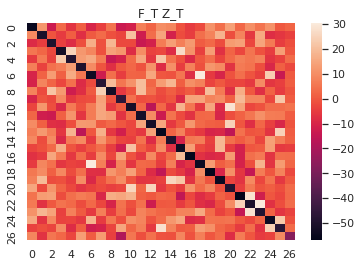

In [71]:
# why does feedback suppress letters
argmin_value = 0
min_value = []
second_min_value = []
feedback_feedforward = o2h.T@h2o.T
for i, row in enumerate(feedback_feedforward[:-1]):
    min_value.append(np.min(row))
    row_deleted_min = np.delete(row, np.argmin(row))
    second_min_value.append(np.min(row_deleted_min))
    if np.argmin(row) == i:
        argmin_value += 1

print("Number of times where argmin value is to row i: ", argmin_value)

distance_to_second_lowest_val = np.asarray(min_value) - np.asarray(second_min_value)

print(np.mean(min_value), np.std(min_value))
print(np.mean(second_min_value), np.std(min_value))

sns.heatmap(o2h.T@h2o.T)
plt.title("F_T Z_T")
plt.show()

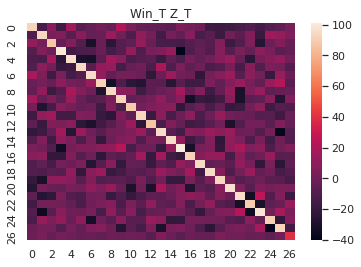

In [72]:
sns.heatmap(i2h.T@h2o.T)
plt.title("Win_T Z_T")
plt.show()



In [73]:
Win_Z_sim = []
for i, out in zip(o2h.T, h2o):
    Win_Z_sim.append(cosine_sim(i, out))
print(Win_Z_sim)

[-0.586, -0.549, -0.539, -0.529, -0.507, -0.552, -0.547, -0.567, -0.56, -0.518, -0.543, -0.538, -0.55, -0.589, -0.558, -0.595, -0.569, -0.563, -0.629, -0.569, -0.516, -0.562, -0.543, -0.523, -0.611, -0.495, -0.208]


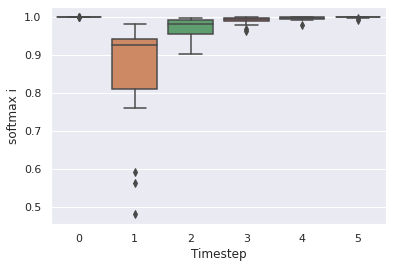

In [74]:
# What we'll do now is run the RNN for 6 timesteps
# However, input will only be given at the first timestep 
df_softmax = pd.DataFrame([], columns=['softmax', 't'])
feedback_only_activity = np.stack(feedback_only_activity).squeeze()
timesteps = 6
output_feedback_rec = {}
output_feedback_rec['Timestep'] = []
output_feedback_rec['softmax i'] = []
for i in range(26):
    for t in range(timesteps):
        # activity when input letter is presented
        if t == 0:
            out_letter = softmax(h_stacked_letter[i]@h2o.T)
            output_feedback_rec['softmax i'].append(out_letter[i])
            output_feedback_rec['Timestep'].append(t)
        # feedback from first timestep
        elif t == 1:
            feedback_rec = sigmoid(h_stacked_letter[i]@h2h.T + feedback_only_activity[i])
            out_letter = softmax(feedback_rec@h2o.T)
            output_feedback_rec['softmax i'].append(out_letter[i])
            output_feedback_rec['Timestep'].append(t)
        # solely driven by recurrent dynamics
        else:
            feedback_rec = sigmoid(feedback_rec@h2h.T)
            out_letter = softmax(feedback_rec@h2o.T)
            output_feedback_rec['softmax i'].append(out_letter[i])
            output_feedback_rec['Timestep'].append(t)
       
pd_output_feedback_rec = pd.DataFrame(output_feedback_rec)
sns.boxplot(x=pd_output_feedback_rec['Timestep'], y=pd_output_feedback_rec['softmax i'])
plt.show()


In [17]:
def impact_of_Wrec(mat, title, xlabel):

    # init. lists
    mag_increase_after_wrec = []
    cosine_sim_change_after_wrec = []
    dot_increase_after_wrec = []

    for i, row in enumerate(mat.T):
        
        # How does W_rec change magnitude?
        row_mag = np.sqrt(np.sum(row**2))
        row_wrecked = row@h2h.T
        row_recked_mag = np.sqrt(np.sum(row_wrecked**2))
        mag_increase_after_wrec.append(row_recked_mag/row_mag)

        # How does W_rec change cosine similarity with corresponding column in h2o?
        h2o_mag = np.sqrt(np.sum(h2o[i]**2))
        cosine_sim = np.dot(row, h2o[i]) / (row_mag*h2o_mag)
        cosine_sim_after_W_wrecked = np.dot(row_wrecked, h2o[i]) / (row_recked_mag * h2o_mag)
        cosine_sim_change_after_wrec.append(cosine_sim_after_W_wrecked - cosine_sim)

        # How does W_rec change dot product with corresponding column in h2o?
        dot_before = np.dot(row, h2o[i])
        dot_after = np.dot(row_wrecked, h2o[i])
        dot_increase_after_wrec.append(dot_after/dot_before)

    fig, ax = plt.subplots(1,3, figsize=(20,4))

    ax[0].plot(mag_increase_after_wrec, marker='o')
    ax[0].set_ylim(0,10)
    ax[0].set_ylabel("Magnitude ratio")

    ax[1].plot(cosine_sim_change_after_wrec, marker='o')
    ax[1].set_ylim(-0.5, 0.5)
    ax[1].set_xlabel(xlabel, fontsize=14)
    ax[1].set_ylabel("Difference in cosine similarity")
    ax[1].set_title(title, fontsize=14)

    ax[2].plot(dot_increase_after_wrec, marker='o')
    ax[2].set_ylim(0,10)
    ax[2].set_ylabel("Dot product ratio")
    
    plt.show()

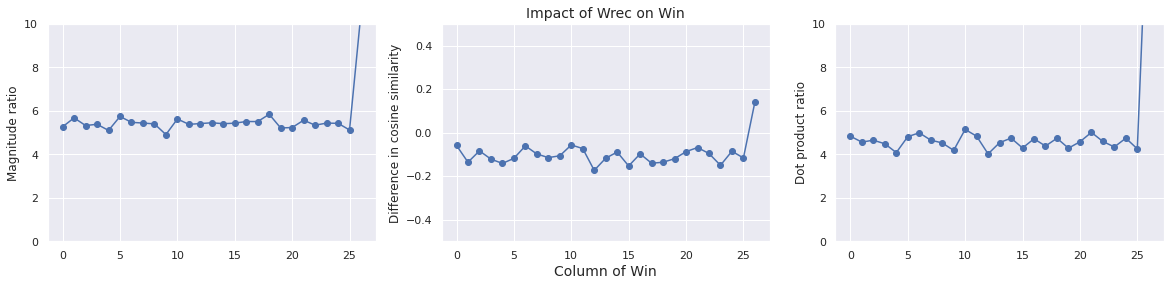

In [18]:
impact_of_Wrec(i2h, title="Impact of Wrec on Win", xlabel="Column of Win")

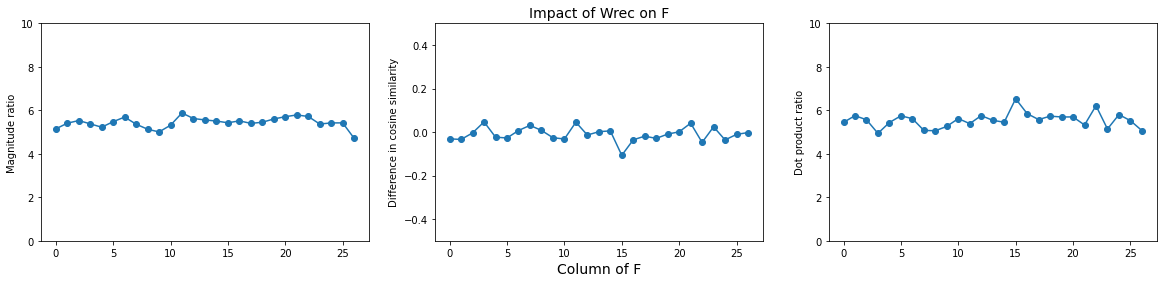

In [18]:
impact_of_Wrec(o2h, title="Impact of Wrec on F", xlabel="Column of F")

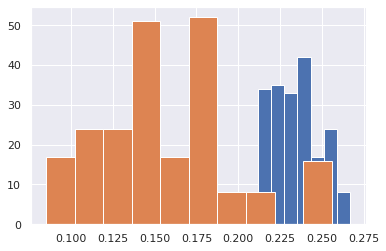

In [19]:
'''
Let's compute cosine similarity between the relevant output vector 
and the hidden activity for the encoding timesteps (list length = 2)

We'll do this separately for the nonlinear and linear case, and then compare. 
'''
rtt = run_test_trials(model, 0.5)
rtt.run_model(device, 2, config, base, fb_type=1)
h_stacked = rtt.h_stacked.numpy()
y_target = rtt.y_test_recall.numpy()
correct_trial_indices = rtt.correct_trials()
h_stacked_correct = h_stacked[:, correct_trial_indices]
y_target_correct = y_target[correct_trial_indices].squeeze()

h_stacked_correct_t1 = h_stacked_correct[0:1].squeeze()
y_target_correct_t1 = y_target_correct[:, 0]

cosine_sim_sigmoid = []
for trial, trial_out in zip(h_stacked_correct_t1, y_target_correct_t1):
    cosine_sim_sigmoid.append(cosine_sim(trial.squeeze(), h2o[trial_out]))

rtt_lin = run_test_trials(model_linear, 0)
rtt_lin.run_model(device, 2, config, base, fb_type=1)
h_stacked_lin = rtt_lin.h_stacked.numpy()
h_stacked_lin_t1 = h_stacked_lin[0:1].squeeze()
y_target_t1 = y_target[:, 0]

cosine_sim_linear = []
for trial, trial_out in zip(h_stacked_lin_t1, y_target_t1):
    cosine_sim_linear.append(cosine_sim(trial.squeeze(), h2o[trial_out]))

plt.hist(cosine_sim_sigmoid)
plt.hist(cosine_sim_linear)
plt.show()

In [20]:
def cosin_sim_rotation_plots(h_arr, y_target, ll):
    
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    
    for j, h_vec in enumerate(h_arr):
        cosine_sim_dict = {}

        for t in range(ll):
            cosine_sim_dict[t] = []

        for h, yarr in zip(h_vec, y_target):

            for i, y in enumerate(yarr):
                out_vec = h2o[y]
                cosine_sim_dict[i].append(cosine_sim(h, out_vec))
                
        ax[j].set_title(f"Timestep {j+ll}", fontsize=16)
        ax[j].hist(cosine_sim_dict[0], alpha=.7, label='letter i', color='b')       
        ax[j].hist(cosine_sim_dict[1], alpha=.7, label='letter j', color='g')
        ax[j].hist(cosine_sim_dict[2], alpha=.7, label='letter k', color='r')   
        ax[j].set_xlabel("Cosine similarity")
    plt.legend()

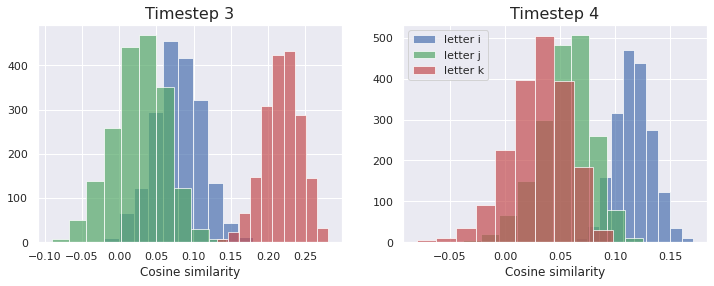

In [21]:
rtt = run_test_trials(model, 0.5)
rtt.run_model(device, 3, config, base, fb_type=1)
h_stacked = rtt.h_stacked.numpy()
y_target = rtt.y_test_recall.numpy()
y_recall = rtt.y_hat_recall.numpy()
y_hat = rtt.y_hat.numpy()
correct_trial_indices = rtt.correct_trials()
h_stacked_correct = h_stacked[:, correct_trial_indices].squeeze()
y_target_correct = y_target[correct_trial_indices].squeeze()

h_stacked_3 = h_stacked_correct[2]
h_stacked_4 = h_stacked_correct[3]

cosin_sim_rotation_plots([h_stacked_3, h_stacked_4], y_target_correct, 3)


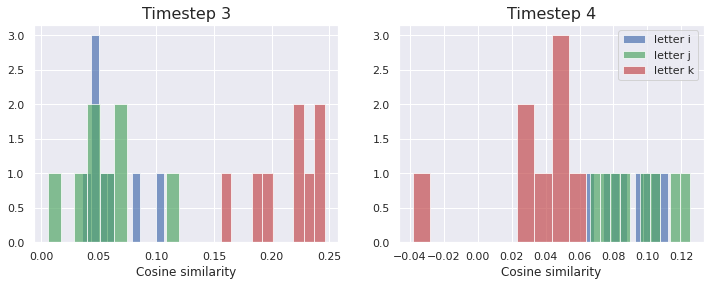

In [22]:
error_first_pos = np.argwhere(y_target[:, 0] != y_recall[:, 0])
h_stacked_error_pos1 = h_stacked[:, error_first_pos].squeeze()
y_target_error_pos1 = y_target[error_first_pos].squeeze()
y_recall_error_pos1 = y_hat[error_first_pos].squeeze()

h_stacked_error_pos1_3 = h_stacked_error_pos1[2]
h_stacked_error_pos1_4 = h_stacked_error_pos1[3]

cosin_sim_rotation_plots([h_stacked_error_pos1_3, h_stacked_error_pos1_4], y_target_error_pos1, 3)

In [20]:
def three_parameter_single_step(input, feedback, Wrec, X_prev):

    return X_prev@Wrec.T + feedback + input 

In [33]:
def three_parameter_model(alpha, beta, gamma, num_letters, list_sequence):

    Wrec = alpha*np.identity(num_letters)
    F = beta*np.identity(num_letters)
    Win = gamma*np.identity(num_letters)
    Z = np.identity(num_letters)

    feedback = np.zeros(num_letters)
    X = np.zeros(num_letters)

    # encoding portion 
    for j, letter in enumerate(list_sequence):
        input_letter = Win.T[letter]
        X = three_parameter_single_step(input_letter, feedback, Wrec, X)
        y = softmax(X@Z.T)
        print(f"Encoding timestep {j}: {np.argmax(y)}")
        outputted_letter = np.argmax(y)
        feedback = F.T[outputted_letter]

    recall_input = np.zeros(num_letters)
    for i in range(len(list_sequence)):
        X = three_parameter_single_step(recall_input, feedback, Wrec, X)
        y = softmax(X@Z.T)
        print(f"Recall timestep {j}: {np.argmax(y)}")
        outputted_letter = np.argmax(y)
        feedback = F.T[outputted_letter]

three_parameter_model(1.2, -1.0, 1.0, 11, [10,3,1,4,5,6,7,8,9,2,0])

Encoding timestep 0: 10
Encoding timestep 1: 3
Encoding timestep 2: 1
Encoding timestep 3: 4
Encoding timestep 4: 5
Encoding timestep 5: 6
Encoding timestep 6: 7
Encoding timestep 7: 8
Encoding timestep 8: 9
Encoding timestep 9: 2
Encoding timestep 10: 10
Recall timestep 10: 0
Recall timestep 10: 3
Recall timestep 10: 1
Recall timestep 10: 4
Recall timestep 10: 5
Recall timestep 10: 6
Recall timestep 10: 7
Recall timestep 10: 0
Recall timestep 10: 8
Recall timestep 10: 3
Recall timestep 10: 9


In [32]:
# load model trained on repetitions
base = '/home3/ebrahim/isr/'


In [49]:
def compute_perf_on_reps_3(modelPath, runPath):
    
    modelPATH = 'saved_models/' +  modelPath + '/model_human.pth'
    runPATH = "ebrahimfeghhi/isr/bsfv6vez"

    api = wandb.Api()
    run = api.run(runPATH)
    config = run.config
    saved_info = torch.load(base + modelPATH)
    model = RNN_one_layer(config['num_letters']+1, config['hs'], config['num_letters']+1, noise_std=config['noise_std'],
                        feedback_bool=True, bias=False)
    model.load_state_dict(saved_info['model_state_dict'])
    rtt = run_test_trials(model, 0.5)
    config['test_path_lists'] = 'test_set/test_lists_3_reps.pkl'
    rtt.run_model(device, 3, config, base, fb_type=1, dict_key='type1')
    type1_correct_ratio = rtt.correct_trials().shape[0]/rtt.y_test_recall.shape[0]
    rtt.run_model(device, 3, config, base, fb_type=1, dict_key='type2')                                    
    type2_correct_ratio = rtt.correct_trials().shape[0]/rtt.y_test_recall.shape[0]
    rtt.run_model(device, 3, config, base, fb_type=1, dict_key='type3')
    type3_correct_ratio = rtt.correct_trials().shape[0]/rtt.y_test_recall.shape[0]
    config['test_path_lists'] = 'test_set/test_lists_dict.pkl'
    rtt.run_model(device,3, config, base, fb_type=1)
    normal_correct_ratio = rtt.correct_trials().shape[0]/rtt.y_test_recall.shape[0]
    return round(type1_correct_ratio,3), round(type2_correct_ratio,3), round(type3_correct_ratio,3), round(normal_correct_ratio,3)



In [89]:
modelPATH = ['feedback_onehot_26_SGD_noise_0.0_nobias', 'SGD_with_repeats_0.1',
            'SGD_with_repeats_0.2', 'SGD_with_repeats_0.3']

runPATH = ["ebrahimfeghhi/isr/gd12r252", "ebrahimfeghhi/isr/4l18pob1", 
            "ebrahimfeghhi/isr/bsfv6vez", "ebrahimfeghhi/isr/hmo989ap"]

rep_correct_ratios_pd = {'accuracy':[], 'training_type':[], 'list_type':[]}

for t_type in ['no_reps', 'rep_0.1', 'rep_0.2', 'rep_0.3']:
    for i in range(4):
        rep_correct_ratios_pd['training_type'].append(t_type)

for m, r in zip(modelPATH, runPATH):
    t1, t2, t3, n = compute_perf_on_reps_3(m, r)
    rep_correct_ratios_pd['accuracy'].append(t1)
    rep_correct_ratios_pd['list_type'].append('type1')
    rep_correct_ratios_pd['accuracy'].append(t2)
    rep_correct_ratios_pd['list_type'].append('type2')
    rep_correct_ratios_pd['accuracy'].append(t3)
    rep_correct_ratios_pd['list_type'].append('type3')
    rep_correct_ratios_pd['accuracy'].append(n)
    rep_correct_ratios_pd['list_type'].append('normal')

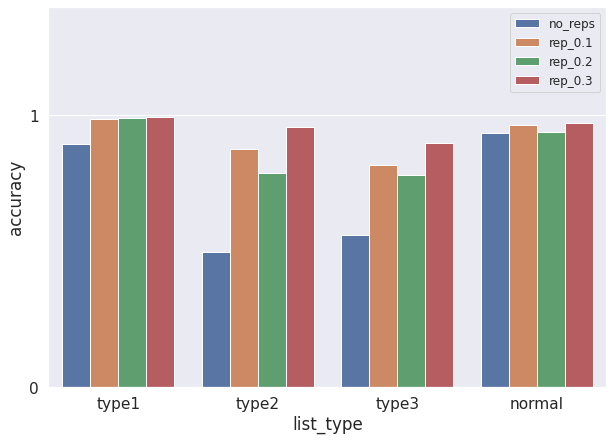

In [90]:
rep_correct_ratios_pd = pd.DataFrame(rep_correct_ratios_pd)
sns.set(font_scale=1.4) 
plt.figure(figsize=(10,7))
plt.ylim(0,1.4)
plt.yticks([0,1])
sns.barplot(data=rep_correct_ratios_pd, x="list_type", y="accuracy", hue="training_type")
plt.legend(loc='upper right', prop={'size':12})